# CBU5201 Mini-Project
# 1. Author

**Student Name:** Minghui Pan

**Student ID:** 231220208

# 2. Problem formulation

This experiment addresses a music identification classification problem. The input is a short Hum/Whistle audio clip from a participant, and the output is one of 8 song labels (an 8-class classification task). The main challenges come from strong inter-person variability, uneven audio quality, and the spectral differences between hums and whistles, which cause large variation for the same song across different singers and vocalization styles. Because the dataset is perfectly balanced, we need a clear overall metric while also examining class-level separability and confusion patterns.

When I discovered the dataset contains only 800 samples, I immediately realized that large-parameter models would be unsuitable—such limited data would easily lead to overfitting, though data augmentation techniques could be considered in later experiments. Furthermore, this is an audio task rather than a text or tabular problem, which means we must transform raw audio into numerical representations through feature extraction. Unlike image recognition tasks where RGB pixel values can directly serve as CNN inputs, audio classification depends entirely on carefully engineered features.

After randomly sampling and listening to several audio clips, I found the problem far more challenging than I had anticipated. The hums and whistles were so abstract that even I, as a human listener, struggled to make confident judgments. This experience inspired an alternative idea: converting audio into images and leveraging CNN-based image classification. Specifically, I considered transforming audio into spectrograms with time on the horizontal axis and pitch on the vertical axis. I quickly prototyped this approach, but unfortunately the results were mediocre—details of this attempt are discussed in the Appendix.

Nevertheless, comparing spectrograms revealed several intriguing patterns. The tonal characteristics of whistles and hums differ substantially: whistles produce cleaner, more concentrated frequency bands, while hums exhibit richer harmonic structures. Moreover, even for the same song, different individuals' hums vary noticeably due to differences in timbre and vocal habits. These observations served as important reminders for my subsequent feature engineering efforts.

After this preliminary analysis and experimentation, I decided to shift my focus away from pursuing maximum accuracy—given such a small-scale dataset with inherently ambiguous features, achieving high classification accuracy would be extremely difficult. Instead, I chose to emphasize a comprehensive and rigorous experimental pipeline, systematic feature extraction, thorough visualization of results, and fair comparison across different models. In the following sections, I will elaborate on my methodology in detail.


# 3 Methodology

## 3.1 Task Formulation

We formulate this problem as an **8-class audio classification task**, where each class corresponds to a distinct song. Given an audio recording of humming or whistling, the model must identify which of the 8 songs is being performed. The primary challenge lies in the inherent variability of human vocalization—different individuals hum at different pitches, tempos, and with varying degrees of accuracy.

## 3.2 Core Design Principles

### 3.2.1 Pitch-Invariant Feature Design

A fundamental observation guides our methodology: **absolute pitch is unreliable for humming/whistling recognition**. When humans hum a melody, they rarely maintain the original key—the same song may be hummed several octaves higher or lower depending on the individual's vocal range. However, the **relative pitch changes (intervals)** and **rhythmic patterns** remain consistent across different performances.

Based on this insight, we prioritize:
- **Normalized pitch features** rather than absolute F0 values
- **Interval sequences** (pitch differences between consecutive frames) that capture melodic contour
- **Rhythm-based features** including onset patterns and tempo estimation

### 3.2.2 Comprehensive Coverage of Course Content

In designing this coursework, we intentionally incorporated **nearly all machine learning concepts covered in the course** to demonstrate a holistic understanding of the subject. This includes feature engineering, dimensionality reduction, unsupervised learning, supervised classification, model selection, and evaluation metrics.

We acknowledge that some components serve overlapping purposes—for instance, both unsupervised clustering analysis and feature importance ranking aim to validate feature quality. Nevertheless, we retain both approaches to showcase different analytical perspectives and to practice the full spectrum of techniques learned throughout the course.

### 3.2.3 Train-Validate-Test Paradigm

We adopt a strict **three-phase evaluation protocol** to ensure unbiased performance estimation:

1. **Development Phase**: All design decisions (feature engineering, model selection, hyperparameter tuning) are made using only the training and validation sets. The test set remains completely isolated.

2. **Deployment Phase**: Once the optimal model and hyperparameters are determined, we retrain on the combined train+validation set to maximize the amount of training data.

3. **Evaluation Phase**: The test set is used exactly once to report final performance metrics.

This protocol prevents information leakage and ensures that reported metrics reflect true generalization capability.

## 3.3 Data Splitting Strategy

We partition the 800 samples using **stratified sampling** to maintain class balance:

| Split | Proportion | Samples | Purpose |
|-------|------------|---------|---------|
| Training | 70% | 560 | Model training and cross-validation |
| Validation | 15% | 120 | Hyperparameter tuning and model selection |
| Test | 15% | 120 | Final unbiased evaluation |

While the course introduced k-fold cross-validation where different folds rotate as the validation set, we opted for a **fixed train-validation-test split** in this project. The 70%-15%-15% ratio is a well-established convention in machine learning practice, and a dedicated held-out validation set provides a consistent benchmark for comparing different models and hyperparameter configurations throughout the development process.

**Critical constraints**:
- Data augmentation is applied **only to the training set**
- Feature normalization statistics (mean, std) are computed **only from the training set** and applied consistently to validation and test sets

## 3.4 Performance Metrics

We employ multiple complementary metrics to comprehensively evaluate model performance:

| Metric | Role | Justification |
|--------|------|---------------|
| **Macro-AUC** | Primary | Measures ranking quality across all classes; evaluates whether the model has learned meaningful patterns |
| Accuracy | Secondary | Intuitive overall correctness measure |
| Macro-F1 | Secondary | Balances precision and recall across classes |
| Confusion Matrix | Diagnostic | Reveals which song pairs are frequently confused |

**Why Macro-AUC as the primary metric?** In an 8-class classification problem, even minor noise or ambiguity can cause misclassification—a sample might be incorrectly assigned to any of the 7 wrong classes. This inherent difficulty means that **raw accuracy is expected to be limited** regardless of model quality. Unlike the typical motivation for using AUC (handling class imbalance), our choice stems from the **large number of classes**: AUC evaluates whether the model assigns higher confidence to the correct class compared to incorrect ones, providing insight into the model's discriminative ability even when hard classification decisions frequently fail. By examining AUC, we can assess whether our model has genuinely learned to distinguish between songs, rather than being misled by superficially low accuracy scores.

## 3.5 Validation Strategy

### 3.5.1 Cross-Validation for Model Selection

During the development phase, we use **5-Fold Stratified Cross-Validation** on the training set to:
- Estimate model performance with reduced variance
- Compare different model architectures fairly
- Select optimal hyperparameters

### 3.5.2 Unsupervised Analysis for Feature Validation

Before supervised training, we perform **unsupervised clustering analysis** (K-Means with K=8) to verify that our features inherently capture song-discriminative information. We evaluate clustering quality using:
- **Normalized Mutual Information (NMI)**: Measures agreement between clusters and true labels
- **Adjusted Rand Index (ARI)**: Quantifies clustering accuracy corrected for chance
- **Silhouette Score**: Assesses cluster compactness and separation

High unsupervised clustering scores indicate that the feature space naturally separates different songs, validating our feature design before any supervised learning occurs.

## 3.6 Model Comparison Strategy

To understand the trade-offs between different approaches, we compare two categories of models:

**Traditional Machine Learning**: KNN and Random Forest operating on hand-crafted feature vectors. These methods offer high interpretability and work well with limited data.

**Deep Learning**: MLP and 1D-CNN architectures. MLP uses the same hand-crafted features, while CNN learns directly from MFCC sequences, providing an end-to-end comparison.

The final model is selected based on validation set Macro-AUC, balancing performance with model complexity and interpretability.

## 3.7 Summary

This section has outlined our **methodology and design philosophy**—the reasoning behind our feature design choices, evaluation metrics, data splitting strategy, and validation approaches. In the following section, we will provide a **detailed description of our implementation pipeline**, including specific feature extraction procedures, data augmentation parameters, model architectures, and the complete workflow from raw audio to final predictions.

# 4 Implemented ML Prediction Pipeline

## 4.1 Pipeline Overview

Our audio classification system follows an 8-stage pipeline that transforms raw audio recordings into song predictions. The figure below illustrates the complete workflow:

```
┌──────────┐    ┌──────────┐    ┌──────────┐    ┌──────────┐
│ Raw Data │───▶│ Feature  │───▶│ Feature  │───▶│Unsupervised
│          │    │ Extract  │    │ Visualize│    │ Analysis │
└──────────┘    └──────────┘    └──────────┘    └────┬─────┘
                                                     │
                                                     ▼
┌──────────┐    ┌──────────┐    ┌──────────┐    ┌──────────┐
│   Test   │◀───│Deployment│◀───│ Training │◀───│ Feature  │
│          │    │          │    │          │    │ Selection│
└──────────┘    └──────────┘    └──────────┘    └──────────┘
```

**Pipeline Input**: 800 raw audio files (`.wav` format) containing humming/whistling recordings of 8 songs

**Pipeline Output**: Trained classifier model + performance metrics on held-out test set

The following table summarizes each stage with its input/output specifications:

| Stage | Input | Output | Purpose |
|-------|-------|--------|---------|
| Data Loading | Raw `.wav` files | Audio arrays + labels | Load and organize dataset |
| Feature Extraction | Audio arrays | Feature matrix (N × 82) | Transform audio to numerical features |
| Feature Visualization | Feature matrix | Diagnostic plots | Understand feature distributions |
| Unsupervised Analysis | Feature matrix | Clustering metrics | Validate feature quality |
| Feature Selection | Feature matrix (N × 82) | Reduced matrix (N × K) | Remove redundant features |
| Training | Train features + labels | Candidate models | Train and compare classifiers |
| Deployment | Train+Val features | Final model (`.pt`) | Produce deployment-ready model |
| Testing | Test features + final model | Performance report | Evaluate generalization |

**Implementation Note**: Since feature extraction is computationally expensive (processing 800 audio files takes considerable time), we save the extracted features to `.npz` files for reuse. Additionally, to clearly demonstrate the train-then-deploy-then-test workflow, we serialize the best model to a `.pt` file after the deployment stage. This design also reflects the author's preference for organizing code as a standard Python project rather than relying heavily on Jupyter notebook's cell-by-cell execution style.

## 4.2 Data Loading and Splitting Stage

**Input**: Directory containing 800 `.wav` audio files with filename-encoded labels

**Process**:
1. Load all audio files using `librosa.load()` with a fixed sample rate (22050 Hz)
2. Parse filenames to extract class labels (song identifiers)
3. Perform stratified split: 70% train (560), 15% validation (120), 15% test (120)

**Output**: Three data partitions, each containing:
- `audio_list`: List of audio waveform arrays (variable length)
- `labels`: Corresponding class labels (integers 0-7)
- `filenames`: Original filenames for traceability

```python
# Output data structure
{
    'train': {'audio': [...], 'labels': [...], 'filenames': [...]},  # 560 samples
    'val':   {'audio': [...], 'labels': [...], 'filenames': [...]},  # 120 samples
    'test':  {'audio': [...], 'labels': [...], 'filenames': [...]}   # 120 samples
}
```

## 4.3 Feature Extraction Stage

**Input**: Audio waveform arrays (variable-length 1D numpy arrays)

**How We Chose These Features**: When starting this project, we searched Google for open-source audio classification projects to understand what features are commonly used for song recognition tasks. We discovered the `librosa` library along with its extensive collection of audio features. Given that we planned to use Random Forest for feature selection later in the pipeline, we adopted a "the more the merrier" approach—extracting as many potentially relevant features as possible and letting the selection stage filter out the unimportant ones. This resulted in an initial feature set of 82 dimensions.

**Process**: Extract three categories of features designed for pitch-invariant melody recognition:

| Feature Category | Extraction Method | Dimensions | Captures |
|------------------|-------------------|------------|----------|
| **Spectral (MFCC)** | `librosa.feature.mfcc` (13 coefficients) → compute mean, std for raw and delta | 52 | Timbre, spectral envelope |
| **Prosodic (F0)** | `librosa.pyin` → normalize F0, compute interval sequence statistics | 20 | Melodic contour (pitch-invariant) |
| **Rhythmic** | `librosa.onset.onset_detect` → IOI statistics + tempo | 10 | Temporal patterns |

**Detailed Feature Breakdown**:

*Spectral Features (52 dimensions)*:
- 13 MFCCs: mean, std → 26 dims
- 13 MFCC deltas: mean, std → 26 dims

*Prosodic Features (20 dimensions)*:
- Normalized F0 (z-score): mean, std, skewness, kurtosis, range → 5 dims
- Interval sequence (semitone differences): mean, std, skewness, kurtosis, range, % positive, % negative, % stable → 10 dims
- Voiced frame ratio → 1 dim
- Pitch range in semitones → 1 dim
- Additional melodic contour statistics → 3 dims

*Rhythmic Features (10 dimensions)*:
- Inter-Onset Interval (IOI): mean, std, max, min, CV → 5 dims
- Tempo (BPM) → 1 dim
- Onset density (onsets/second) → 1 dim
- Rhythm regularity metrics → 3 dims

**Output**: Feature matrix `X` of shape `(N, 82)` where N is number of samples. Features are saved to `features.npz` for efficient reloading.

```python
# Output data structure (saved to .npz)
X_train: np.ndarray  # shape (560, 82)
X_val:   np.ndarray  # shape (120, 82)
X_test:  np.ndarray  # shape (120, 82)
```

## 4.4 Data Augmentation Stage (Training Set Only)

**Input**: Training audio arrays (560 samples)

**Why Data Augmentation?** With only 800 total samples (560 for training), our dataset is quite limited for training a robust classifier. To improve model generalization and prevent overfitting, we apply data augmentation to artificially increase the diversity of our training data.

**Critical Constraint**: Augmented samples are **strictly applied to the training set only**. Including augmented data in the validation or test sets would compromise the integrity of our evaluation—the model might appear to perform better simply because it has seen similar variants during training. To ensure rigorous and honest evaluation, we keep the validation and test sets completely untouched.

**Process**: Apply audio transformations to increase training data diversity:

| Augmentation | Implementation | Parameters | Motivation |
|--------------|----------------|------------|------------|
| Pitch Shift | `librosa.effects.pitch_shift` | ±2, ±3 semitones | Simulate pitch inaccuracy in humming |
| Time Stretch | `librosa.effects.time_stretch` | 0.9×, 1.1× | Simulate tempo variation |
| Noise Addition | Add Gaussian noise | SNR 25-35 dB | Improve robustness |

**Augmentation Strategy**: Each training sample generates 2-3 augmented variants

**Output**: Augmented training set (~1500-2000 samples) → extract features → `X_train_aug` of shape `(~1700, 82)`

## 4.5 Feature Visualization Stage

**Input**: Feature matrix `X_train` with labels `y_train`

**Process**: Generate diagnostic visualizations to understand feature space structure:

| Visualization | Method | Insight Gained |
|---------------|--------|----------------|
| Box plots | Per-class distribution of top features | Class separability in individual features |
| Correlation heatmap | Pearson correlation matrix | Identify redundant feature pairs |
| PCA projection | 2D/3D scatter plot | Linear separability assessment |
| t-SNE projection | 2D scatter plot (perplexity=30) | Cluster structure in feature space |

**Output**: Saved figure files (`.png`) + qualitative observations guiding subsequent stages

## 4.6 Unsupervised Analysis Stage

**Input**: Feature matrix `X_train` (without using labels for clustering)

**Process**:
1. Apply K-Means clustering with K=8
2. Compare cluster assignments with true labels
3. Compute clustering quality metrics

**Metrics Computed**:
| Metric | Formula Interpretation | Threshold for "Good" |
|--------|------------------------|----------------------|
| NMI | Information shared between clusters and labels | > 0.5 |
| ARI | Rand index adjusted for chance | > 0.3 |
| Silhouette | Intra-cluster vs inter-cluster distance | > 0.2 |

**Output**: Clustering metrics dictionary + cluster-label confusion matrix

```python
# Output data structure
{
    'nmi': 0.XX,
    'ari': 0.XX,
    'silhouette': 0.XX,
    'cluster_label_matrix': np.ndarray  # shape (8, 8)
}
```

## 4.7 Feature Selection Stage

**Input**: Feature matrix `X_train` of shape `(N, 82)` with labels `y_train`

**Process**: We use the classic **Random Forest feature importance** method for feature ranking. This approach is well-established in the machine learning community and provides interpretable importance scores based on how much each feature contributes to reducing impurity in the decision trees.

1. Train a Random Forest classifier on training data
2. Extract `feature_importances_` scores
3. Rank features by importance
4. Select top-K features (K determined by validation performance, typically 30-50)
5. Remove highly correlated features (|r| > 0.95) from selected set

**Output**:
- Selected feature indices: `List[int]` of length K
- Reduced feature matrices: `X_train_selected` (N, K), `X_val_selected`, `X_test_selected`
- Feature importance ranking plot

```python
# Output data structure
selected_features: List[int]  # e.g., [0, 3, 5, 12, 15, ...]
X_train_selected: np.ndarray  # shape (N_train, K)
X_val_selected:   np.ndarray  # shape (N_val, K)
X_test_selected:  np.ndarray  # shape (N_test, K)
```

## 4.8 Model Training Stage

**Input**: Selected training features `X_train_selected` with labels `y_train`

**Process**: Train and evaluate multiple classifier architectures using 5-Fold Stratified CV:

| Model | Input Format | Hyperparameter Search Space |
|-------|--------------|----------------------------|
| **KNN** | Feature vector (K dims) | n_neighbors ∈ {3,5,7,9}, weights ∈ {uniform, distance} |
| **Random Forest** | Feature vector (K dims) | n_estimators ∈ {100,200}, max_depth ∈ {5,10,None} |
| **MLP** | Feature vector (K dims) | hidden_layers ∈ {(128,64), (256,128)}, dropout ∈ {0.3,0.5} |
| **1D-CNN** | MFCC sequence (T×13) | filters ∈ {32,64}, kernel_size ∈ {3,5} |

**Training Protocol**:
``` markdown
For each model type:
    For each hyperparameter combination:
        Perform 5-Fold CV on X_train_selected
        Record mean CV Macro-AUC
    Select best hyperparameters
    Retrain on full training set
    Evaluate on validation set
    Record validation Macro-AUC
```

**Output**: 
- Best model per architecture with optimal hyperparameters
- Validation performance comparison table

## 4.9 Deployment Stage

**Input**: 
- Best performing model architecture and hyperparameters (from Training Stage)
- Combined train + validation features `X_trainval_selected`

**Process**:
1. Merge training and validation sets
2. Retrain the selected model on combined data
3. Serialize model to disk as `best_model.pt`

**Output**: 
- `best_model.pt`: Trained classifier ready for inference
- `feature_selector.pkl`: Feature selection configuration for preprocessing new data
- `scaler.pkl`: Feature normalization parameters

## 4.10 Testing Stage

**Input**: 
- Test features `X_test_selected` (120 samples)
- Test labels `y_test`
- Trained model `best_model.pt`

**Process**:
1. Load final model
2. Generate predictions and probability scores
3. Compute evaluation metrics
4. Generate diagnostic visualizations

**Output**: Final performance report containing:

```python
# Output data structure
{
    'macro_auc': float,
    'accuracy': float,
    'macro_f1': float,
    'confusion_matrix': np.ndarray,  # shape (8, 8)
    'per_class_auc': List[float],    # length 8
    'classification_report': str
}
```

**Visualizations Generated**:
- Confusion matrix heatmap
- Per-class ROC curves
- Feature importance bar chart (top 20)


## 5. Dataset

## 5.1 Dataset Overview

Our dataset is derived from the **MLEnd Hums and Whistles II Dataset**, containing 800 audio recordings of humming and whistling performances across 8 different songs. Each song has approximately 100 samples, recorded by various individuals with different vocal characteristics and pitch accuracy.

| Property | Value |
|----------|-------|
| Total samples | 800 |
| Number of classes | 8 (songs) |
| Samples per class | ~100 |
| Audio format | `.wav` |
| Sample rate | 22050 Hz |

## 5.2 Data Splitting

We create three independent datasets through stratified sampling:

| Dataset | Samples | Proportion | Purpose |
|---------|---------|------------|---------|
| **Training Set** | 560 | 70% | Model training (with augmentation) |
| **Validation Set** | 120 | 15% | Hyperparameter tuning, model selection |
| **Test Set** | 120 | 15% | Final evaluation (used only once) |

**Stratified sampling** ensures that each split maintains the same class distribution as the original dataset, preventing any class from being underrepresented in any partition.

## 5.3 Independence and IID Considerations

To ensure the validity of our evaluation:

1. **Temporal independence**: The split is performed randomly without considering recording order, treating each sample as an independent observation.

2. **No data leakage**: Augmented samples are generated **only from training data** and never mixed into validation or test sets.

3. **Feature statistics isolation**: Normalization parameters (mean, std) are computed **exclusively from the training set** and applied to all three sets.

## 5.4 Limitations

We acknowledge the following limitations of our dataset:

| Limitation | Impact | Mitigation |
|------------|--------|------------|
| **Small sample size** (800 total) | Higher risk of overfitting; limited statistical power | Data augmentation; simpler models; cross-validation |
| **Possible performer overlap** | Same person may appear in train and test, inflating performance | Not addressable without performer metadata |
| **Recording condition variance** | Different devices/environments may introduce confounding factors | Noise augmentation for robustness |
| **Class definition ambiguity** | Some songs may have similar melodic patterns | Accept potential confusion between similar songs |

## 5.5 Dataset Construction

The following code constructs our training, validation, and test datasets:

In [13]:
import librosa
import numpy as np
from __future__ import annotations
import os
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Iterable, List, Tuple
from sklearn.model_selection import GroupShuffleSplit
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("VECLIB_MAXIMUM_THREADS", "1")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")
os.environ.setdefault("NUMBA_DISABLE_JIT", "1")

'1'

In [14]:
DATASET_DIR = Path("/Users/panmingh/Code/ML_Coursework/Data/MLEndHWII_sample_800")
DEFAULT_OUTPUT_DIR = Path("/Users/panmingh/Code/ML_Coursework/")

try:
    from tqdm import tqdm
except Exception:  # pragma: no cover - fallback when tqdm is unavailable
    tqdm = None

In [15]:
@dataclass
class FeatureConfig:
    sr: int = 22050
    n_mfcc: int = 13
    hop_length: int = 512
    fmin: float = librosa.note_to_hz("C2")
    fmax: float = librosa.note_to_hz("C7")
    onset_backtrack: bool = True


In [16]:
def _safe_stats(x: np.ndarray) -> Tuple[float, float, float, float]:
    if x.size == 0:
        return 0.0, 0.0, 0.0, 0.0
    return float(np.mean(x)), float(np.std(x)), float(np.max(x)), float(np.min(x))


def _safe_mean_std(x: np.ndarray) -> Tuple[float, float]:
    if x.size == 0:
        return 0.0, 0.0
    return float(np.mean(x)), float(np.std(x))


def _nan_to_num(x: np.ndarray) -> np.ndarray:
    return np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)

In [17]:
def load_audio(path: str, cfg: FeatureConfig) -> Tuple[np.ndarray, int]:
    y, sr = librosa.load(path, sr=cfg.sr, mono=True)
    if y.size == 0:
        return np.zeros(1, dtype=np.float32), cfg.sr
    return y, sr

In [18]:
def mfcc_features(y: np.ndarray, cfg: FeatureConfig) -> List[float]:
    mfcc = librosa.feature.mfcc(
        y=y, sr=cfg.sr, n_mfcc=cfg.n_mfcc, hop_length=cfg.hop_length
    )
    delta = librosa.feature.delta(mfcc)

    mfcc = _nan_to_num(mfcc)
    delta = _nan_to_num(delta)

    feats: List[float] = []
    feats.extend(np.mean(mfcc, axis=1).tolist())
    feats.extend(np.std(mfcc, axis=1).tolist())
    feats.extend(np.mean(delta, axis=1).tolist())
    feats.extend(np.std(delta, axis=1).tolist())
    return feats


In [19]:
def f0_features(y: np.ndarray, cfg: FeatureConfig) -> List[float]:
    f0, voiced_flag, voiced_prob = librosa.pyin(
        y,
        fmin=cfg.fmin,
        fmax=cfg.fmax,
        sr=cfg.sr,
        hop_length=cfg.hop_length,
    )
    f0 = _nan_to_num(f0)
    voiced_flag = voiced_flag.astype(np.float32) if voiced_flag is not None else None

    voiced_ratio = 0.0
    if voiced_flag is not None and voiced_flag.size > 0:
        voiced_ratio = float(np.mean(voiced_flag))

    f0_mean, f0_std = _safe_mean_std(f0)
    if f0_std > 0:
        f0_norm = (f0 - f0_mean) / f0_std
    else:
        f0_norm = f0 - f0_mean

    f0n_mean, f0n_std = _safe_mean_std(f0_norm)
    f0n_max, f0n_min = (float(np.max(f0_norm)), float(np.min(f0_norm))) if f0_norm.size else (0.0, 0.0)
    f0n_median = float(np.median(f0_norm)) if f0_norm.size else 0.0

    # Interval in semitones between adjacent frames.
    f0_nonzero = np.where(f0 > 0, f0, np.nan)
    intervals = 12.0 * np.log2(f0_nonzero[1:] / f0_nonzero[:-1])
    intervals = _nan_to_num(intervals)

    int_mean, int_std, int_max, int_min = _safe_stats(intervals)
    int_median = float(np.median(intervals)) if intervals.size else 0.0
    int_iqr = float(np.percentile(intervals, 75) - np.percentile(intervals, 25)) if intervals.size else 0.0
    int_abs_mean = float(np.mean(np.abs(intervals))) if intervals.size else 0.0
    int_abs_std = float(np.std(np.abs(intervals))) if intervals.size else 0.0
    int_pos_ratio = float(np.mean(intervals > 0)) if intervals.size else 0.0
    int_neg_ratio = float(np.mean(intervals < 0)) if intervals.size else 0.0

    # Melodic contour proportions.
    eps = 1e-4
    up_ratio = float(np.mean(intervals > eps)) if intervals.size else 0.0
    down_ratio = float(np.mean(intervals < -eps)) if intervals.size else 0.0
    flat_ratio = float(np.mean(np.abs(intervals) <= eps)) if intervals.size else 0.0

    feats = [
        f0n_mean,
        f0n_std,
        f0n_max,
        f0n_min,
        f0n_median,
        int_mean,
        int_std,
        int_max,
        int_min,
        int_median,
        int_iqr,
        int_abs_mean,
        int_abs_std,
        int_pos_ratio,
        int_neg_ratio,
        up_ratio,
        down_ratio,
        flat_ratio,
        voiced_ratio,
        float(np.mean(_nan_to_num(voiced_prob))) if voiced_prob is not None else 0.0,
    ]
    return feats

In [20]:
def _estimate_tempo(onset_env: np.ndarray, cfg: FeatureConfig) -> float:
    if onset_env.size < 2:
        return 0.0
    onset_env = onset_env - np.mean(onset_env)
    if np.allclose(onset_env, 0.0):
        return 0.0
    ac = np.correlate(onset_env, onset_env, mode="full")[onset_env.size - 1 :]
    min_bpm, max_bpm = 30.0, 240.0
    min_lag = int((60.0 * cfg.sr) / (max_bpm * cfg.hop_length))
    max_lag = int((60.0 * cfg.sr) / (min_bpm * cfg.hop_length))
    min_lag = max(min_lag, 1)
    max_lag = min(max_lag, ac.size - 1)
    if max_lag <= min_lag:
        return 0.0
    lag = int(np.argmax(ac[min_lag : max_lag + 1]) + min_lag)
    return float(60.0 * cfg.sr / (cfg.hop_length * lag))


def rhythm_features(y: np.ndarray, cfg: FeatureConfig) -> List[float]:
    onset_env = librosa.onset.onset_strength(y=y, sr=cfg.sr, hop_length=cfg.hop_length)
    onset_frames = librosa.onset.onset_detect(
        onset_envelope=onset_env,
        sr=cfg.sr,
        hop_length=cfg.hop_length,
        backtrack=cfg.onset_backtrack,
    )
    onset_times = librosa.frames_to_time(onset_frames, sr=cfg.sr, hop_length=cfg.hop_length)
    ioi = np.diff(onset_times)
    ioi_mean, ioi_std, ioi_max, ioi_min = _safe_stats(ioi)

    tempo = _estimate_tempo(onset_env, cfg)
    duration = float(len(y)) / float(cfg.sr) if cfg.sr > 0 else 0.0
    onsets_per_sec = float(len(onset_times) / duration) if duration > 0 else 0.0

    return [
        ioi_mean,
        ioi_std,
        ioi_max,
        ioi_min,
        tempo,
        onsets_per_sec,
    ]


In [21]:
def extract_features(path: str, cfg: FeatureConfig | None = None) -> np.ndarray:
    cfg = cfg or FeatureConfig()
    y, _ = load_audio(path, cfg)
    feats: List[float] = []
    feats.extend(mfcc_features(y, cfg))
    feats.extend(f0_features(y, cfg))
    feats.extend(rhythm_features(y, cfg))
    return np.asarray(feats, dtype=np.float32)


def batch_extract(
    paths: Iterable[str], cfg: FeatureConfig | None = None
) -> Tuple[np.ndarray, List[str]]:
    cfg = cfg or FeatureConfig()
    features: List[np.ndarray] = []
    ok_paths: List[str] = []
    path_list = list(paths)
    if tqdm is not None:
        iterator = tqdm(path_list, desc="Extracting features", unit="file")
    else:
        iterator = path_list
    for idx, p in enumerate(iterator, start=1):
        feats = extract_features(p, cfg)
        features.append(feats)
        ok_paths.append(p)
        if tqdm is None and idx % 50 == 0:
            print(f"Processed {idx}/{len(path_list)} files...")
    return np.vstack(features), ok_paths


def feature_names(cfg: FeatureConfig | None = None) -> List[str]:
    cfg = cfg or FeatureConfig()
    names: List[str] = []
    for i in range(cfg.n_mfcc):
        names.append(f"mfcc_mean_{i+1}")
    for i in range(cfg.n_mfcc):
        names.append(f"mfcc_std_{i+1}")
    for i in range(cfg.n_mfcc):
        names.append(f"mfcc_delta_mean_{i+1}")
    for i in range(cfg.n_mfcc):
        names.append(f"mfcc_delta_std_{i+1}")

    names.extend(
        [
            "f0n_mean",
            "f0n_std",
            "f0n_max",
            "f0n_min",
            "f0n_median",
            "interval_mean",
            "interval_std",
            "interval_max",
            "interval_min",
            "interval_median",
            "interval_iqr",
            "interval_abs_mean",
            "interval_abs_std",
            "interval_pos_ratio",
            "interval_neg_ratio",
            "contour_up_ratio",
            "contour_down_ratio",
            "contour_flat_ratio",
            "voiced_ratio",
            "voiced_prob_mean",
        ]
    )

    names.extend(
        [
            "ioi_mean",
            "ioi_std",
            "ioi_max",
            "ioi_min",
            "tempo",
            "onsets_per_sec",
        ]
    )
    return names


def as_dict(path: str, cfg: FeatureConfig | None = None) -> Dict[str, float]:
    cfg = cfg or FeatureConfig()
    feats = extract_features(path, cfg)
    names = feature_names(cfg)
    return {k: float(v) for k, v in zip(names, feats)}


In [22]:
def _parse_metadata(path: Path) -> Dict[str, str]:
    stem = path.stem
    parts = stem.split("_")
    meta = {"subject": "", "mode": "", "take": "", "song": ""}
    if len(parts) >= 4:
        meta["subject"] = parts[0]
        meta["mode"] = parts[1]
        meta["take"] = parts[2]
        meta["song"] = "_".join(parts[3:])
    else:
        meta["song"] = stem
    return meta


def collect_wav_paths(data_dir: Path) -> List[Path]:
    return sorted([p for p in data_dir.glob("*.wav") if p.is_file()])


def save_features(
    features: np.ndarray,
    paths: List[str],
    names: List[str],
    meta: List[Dict[str, str]],
    out_dir: Path,
    prefix: str,
) -> None:
    out_dir.mkdir(parents=True, exist_ok=True)
    npz_path = out_dir / f"{prefix}.npz"
    csv_path = out_dir / f"{prefix}.csv"

    labels = [m.get("song", "") for m in meta]
    np.savez_compressed(
        npz_path,
        X=features,
        labels=np.asarray(labels),
        paths=np.asarray(paths),
        feature_names=np.asarray(names),
        subject=np.asarray([m.get("subject", "") for m in meta]),
        mode=np.asarray([m.get("mode", "") for m in meta]),
        take=np.asarray([m.get("take", "") for m in meta]),
    )

    header = ["path", "label", "subject", "mode", "take"] + names
    with csv_path.open("w", encoding="utf-8", newline="") as f:
        f.write(",".join(header) + "\n")
        for row_idx, p in enumerate(paths):
            row = [
                p,
                labels[row_idx],
                meta[row_idx].get("subject", ""),
                meta[row_idx].get("mode", ""),
                meta[row_idx].get("take", ""),
            ]
            feat_str = [f"{v:.8f}" for v in features[row_idx].tolist()]
            f.write(",".join(row + feat_str) + "\n")


In [27]:
# NOTE: We already extracted and saved the features offline, so re-running
# this block is unnecessary and can be time-consuming.
# cfg = FeatureConfig()
# wav_paths = collect_wav_paths(DATASET_DIR)
# features, ok_paths = batch_extract([str(p) for p in wav_paths], cfg)
# meta = [_parse_metadata(Path(p)) for p in ok_paths]
# names = feature_names(cfg)
# save_features(features, ok_paths, names, meta, DEFAULT_OUTPUT_DIR, "features")

In [23]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Iterable, List, Tuple

import librosa
import numpy as np
from scipy.io import wavfile

# ---------------------------------------------------------------------
# 1) Paths (edit for your machine)
# ---------------------------------------------------------------------
DATASET_DIR = Path("/Users/panmingh/Code/ML_Coursework/Data/MLEndHWII_sample_800")
DEFAULT_OUTPUT_DIR = Path("/Users/panmingh/Code/ML_Coursework/MyCourse/data/augmented")


# ---------------------------------------------------------------------
# 2) Augmentation config
# ---------------------------------------------------------------------
@dataclass
class AugmentConfig:
    sr: int = 22050
    pitch_shift_steps: Tuple[int, int] = (-3, 3)
    time_stretch_range: Tuple[float, float] = (0.9, 1.1)
    snr_db_range: Tuple[float, float] = (20.0, 40.0)


# ---------------------------------------------------------------------
# 3) Audio loading
# ---------------------------------------------------------------------
def load_audio(path: str | Path, cfg: AugmentConfig) -> np.ndarray:
    y, _ = librosa.load(str(path), sr=cfg.sr, mono=True)
    if y.size == 0:
        return np.zeros(1, dtype=np.float32)
    return y.astype(np.float32, copy=False)


# ---------------------------------------------------------------------
# 4) Augmentation ops
# ---------------------------------------------------------------------
def pitch_shift(y: np.ndarray, cfg: AugmentConfig, rng: np.random.Generator) -> np.ndarray:
    steps = rng.integers(cfg.pitch_shift_steps[0], cfg.pitch_shift_steps[1] + 1)
    if steps == 0:
        return y
    return librosa.effects.pitch_shift(y, sr=cfg.sr, n_steps=int(steps))


def time_stretch(y: np.ndarray, cfg: AugmentConfig, rng: np.random.Generator) -> np.ndarray:
    rate = rng.uniform(cfg.time_stretch_range[0], cfg.time_stretch_range[1])
    if np.isclose(rate, 1.0):
        return y
    return librosa.effects.time_stretch(y, rate=float(rate))


def add_noise(y: np.ndarray, cfg: AugmentConfig, rng: np.random.Generator) -> np.ndarray:
    snr_db = rng.uniform(cfg.snr_db_range[0], cfg.snr_db_range[1])
    if y.size == 0:
        return y
    signal_power = np.mean(y**2) + 1e-12
    snr_linear = 10 ** (snr_db / 10.0)
    noise_power = signal_power / snr_linear
    noise = rng.normal(0.0, np.sqrt(noise_power), size=y.shape).astype(np.float32)
    return y + noise


def augment_sample(
    y: np.ndarray, cfg: AugmentConfig, rng: np.random.Generator
) -> List[np.ndarray]:
    variants = []
    variants.append(pitch_shift(y, cfg, rng))
    variants.append(time_stretch(y, cfg, rng))
    variants.append(add_noise(y, cfg, rng))
    return variants


# ---------------------------------------------------------------------
# 5) Batch helpers
# ---------------------------------------------------------------------
def augment_path(
    path: str | Path,
    cfg: AugmentConfig | None = None,
    seed: int | None = None,
) -> List[np.ndarray]:
    cfg = cfg or AugmentConfig()
    rng = np.random.default_rng(seed)
    y = load_audio(path, cfg)
    return augment_sample(y, cfg, rng)


def batch_augment(
    paths: Iterable[str | Path],
    cfg: AugmentConfig | None = None,
    seed: int | None = None,
) -> List[Tuple[Path, List[np.ndarray]]]:
    cfg = cfg or AugmentConfig()
    rng = np.random.default_rng(seed)
    out: List[Tuple[Path, List[np.ndarray]]] = []
    for p in paths:
        path = Path(p)
        y = load_audio(path, cfg)
        out.append((path, augment_sample(y, cfg, rng)))
    return out


# ---------------------------------------------------------------------
# 6) Saving to .wav (optional)
# ---------------------------------------------------------------------
def _normalize_to_int16(y: np.ndarray) -> np.ndarray:
    if y.size == 0:
        return np.zeros(1, dtype=np.int16)
    peak = np.max(np.abs(y))
    if peak <= 0:
        return np.zeros_like(y, dtype=np.int16)
    y = y / peak
    return (y * 32767.0).astype(np.int16)


def save_augmented(
    src_path: Path,
    variants: List[np.ndarray],
    out_dir: Path,
    cfg: AugmentConfig,
) -> None:
    out_dir.mkdir(parents=True, exist_ok=True)
    stem = src_path.stem
    suffixes = ["ps", "ts", "noise"]
    for idx, y_aug in enumerate(variants):
        tag = suffixes[idx] if idx < len(suffixes) else f"aug{idx+1}"
        out_path = out_dir / f"{stem}_{tag}.wav"
        wavfile.write(out_path, cfg.sr, _normalize_to_int16(y_aug))


In [24]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
from sklearn.model_selection import GroupShuffleSplit

# ---------------------------------------------------------------------
# 1) Paths (edit for your machine)
# ---------------------------------------------------------------------
DATASET_DIR = Path("/Users/panmingh/Code/ML_Coursework/Data/MLEndHWII_sample_800")
DEFAULT_FEATURES = Path("/Users/panmingh/Code/ML_Coursework/MyCourse/results/features.npz")
DEFAULT_OUT_DIR = Path("/Users/panmingh/Code/ML_Coursework/MyCourse/results/splits")

try:
    from tqdm import tqdm
except Exception:  # pragma: no cover - fallback when tqdm is unavailable
    tqdm = None


# ---------------------------------------------------------------------
# 2) Config for subject-wise split
# ---------------------------------------------------------------------
@dataclass
class SplitConfig:
    train_ratio: float = 0.7
    val_ratio: float = 0.15
    test_ratio: float = 0.15
    seed: int = 42


# ---------------------------------------------------------------------
# 3) IO helpers for .npz features
# ---------------------------------------------------------------------
def load_features_npz(path: Path) -> Dict[str, np.ndarray]:
    data = np.load(path, allow_pickle=True)
    return {k: data[k] for k in data.files}


def save_features_npz(
    out_path: Path,
    X: np.ndarray,
    labels: np.ndarray,
    paths: np.ndarray,
    feature_names: np.ndarray,
    subject: np.ndarray,
    mode: np.ndarray,
    take: np.ndarray,
) -> None:
    out_path.parent.mkdir(parents=True, exist_ok=True)
    np.savez_compressed(
        out_path,
        X=X,
        labels=labels,
        paths=paths,
        feature_names=feature_names,
        subject=subject,
        mode=mode,
        take=take,
    )


# ---------------------------------------------------------------------
# 4) Split by subject (group split)
# ---------------------------------------------------------------------
def split_by_subject(
    subjects: np.ndarray, cfg: SplitConfig
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    if not np.isclose(cfg.train_ratio + cfg.val_ratio + cfg.test_ratio, 1.0):
        raise ValueError("Train/val/test ratios must sum to 1.0")

    gss = GroupShuffleSplit(
        n_splits=1, train_size=cfg.train_ratio, random_state=cfg.seed
    )
    idx = np.arange(subjects.shape[0])
    train_idx, temp_idx = next(gss.split(idx, groups=subjects))

    temp_subjects = subjects[temp_idx]
    val_ratio = cfg.val_ratio / (cfg.val_ratio + cfg.test_ratio)
    gss2 = GroupShuffleSplit(n_splits=1, train_size=val_ratio, random_state=cfg.seed)
    val_sub_idx, test_sub_idx = next(gss2.split(temp_idx, groups=temp_subjects))
    val_idx = temp_idx[val_sub_idx]
    test_idx = temp_idx[test_sub_idx]
    return train_idx, val_idx, test_idx


# ---------------------------------------------------------------------
# 5) Augment audio and extract features
# ---------------------------------------------------------------------
def extract_features_from_audio(y: np.ndarray, cfg: FeatureConfig) -> np.ndarray:
    feats: List[float] = []
    feats.extend(mfcc_features(y, cfg))
    feats.extend(f0_features(y, cfg))
    feats.extend(rhythm_features(y, cfg))
    return np.asarray(feats, dtype=np.float32)


def augment_and_extract(
    paths: List[str],
    subjects: np.ndarray,
    modes: np.ndarray,
    takes: np.ndarray,
    cfg_feat: FeatureConfig,
    cfg_aug: AugmentConfig,
    seed: int,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    rng = np.random.default_rng(seed)
    feats_list: List[np.ndarray] = []
    labels_list: List[str] = []
    paths_list: List[str] = []
    subj_list: List[str] = []
    mode_list: List[str] = []
    take_list: List[str] = []

    iterator = tqdm(paths, desc="Augmenting train", unit="file") if tqdm else paths
    for i, p in enumerate(iterator):
        y = load_audio(p, cfg_aug)
        variants = augment_sample(y, cfg_aug, rng)
        base_label = Path(p).stem.split("_", 3)[-1]
        for j, y_aug in enumerate(variants):
            feats_list.append(extract_features_from_audio(y_aug, cfg_feat))
            labels_list.append(base_label)
            paths_list.append(f"{p}::aug{j+1}")
            subj_list.append(str(subjects[i]))
            mode_list.append(str(modes[i]))
            take_list.append(str(takes[i]))
        if tqdm is None and (i + 1) % 50 == 0:
            print(f"Augmented {i+1}/{len(paths)} files...")

    return (
        np.vstack(feats_list) if feats_list else np.zeros((0, 0), dtype=np.float32),
        np.asarray(labels_list),
        np.asarray(paths_list),
        np.asarray(subj_list),
        np.asarray(mode_list),
        np.asarray(take_list),
    )

In [28]:
# data = load_features_npz(DEFAULT_FEATURES)
# X = data["X"]
# labels = data["labels"].astype(str)
# paths = data["paths"].astype(str)
# feature_names = data["feature_names"]
# subject = data.get("subject")
# mode = data.get("mode")
# take = data.get("take")

# if subject is None or mode is None or take is None:
#     raise ValueError("features.npz missing subject/mode/take; re-run features.py.")

# split_cfg = SplitConfig(seed=42)
# train_idx, val_idx, test_idx = split_by_subject(subject, split_cfg)

# save_features_npz(
#     DEFAULT_OUT_DIR / "train.npz",
#     X[train_idx],
#     labels[train_idx],
#     paths[train_idx],
#     feature_names,
#     subject[train_idx],
#     mode[train_idx],
#     take[train_idx],
# )
# save_features_npz(
#     DEFAULT_OUT_DIR / "val.npz",
#     X[val_idx],
#     labels[val_idx],
#     paths[val_idx],
#     feature_names,
#     subject[val_idx],
#     mode[val_idx],
#     take[val_idx],
# )
# save_features_npz(
#     DEFAULT_OUT_DIR / "test.npz",
#     X[test_idx],
#     labels[test_idx],
#     paths[test_idx],
#     feature_names,
#     subject[test_idx],
#     mode[test_idx],
#     take[test_idx],
# )

# cfg_feat = FeatureConfig()
# cfg_aug = AugmentConfig()
# train_paths = [str(DATASET_DIR / Path(p).name) for p in paths[train_idx]]
# X_aug, y_aug, p_aug, s_aug, m_aug, t_aug = augment_and_extract(
#     train_paths,
#     subject[train_idx],
#     mode[train_idx],
#     take[train_idx],
#     cfg_feat,
#     cfg_aug,
#     seed=42,
# )

# save_features_npz(
#     DEFAULT_OUT_DIR / "train_aug.npz",
#     X_aug,
#     y_aug,
#     p_aug,
#     feature_names,
#     s_aug,
#     m_aug,
#     t_aug,
# )

# X_train_full = np.vstack([X[train_idx], X_aug]) if X_aug.size else X[train_idx]
# y_train_full = (
#     np.concatenate([labels[train_idx], y_aug]) if y_aug.size else labels[train_idx]
# )
# p_train_full = (
#     np.concatenate([paths[train_idx], p_aug]) if p_aug.size else paths[train_idx]
# )
# s_train_full = (
#     np.concatenate([subject[train_idx], s_aug]) if s_aug.size else subject[train_idx]
# )
# m_train_full = (
#     np.concatenate([mode[train_idx], m_aug]) if m_aug.size else mode[train_idx]
# )
# t_train_full = (
#     np.concatenate([take[train_idx], t_aug]) if t_aug.size else take[train_idx]
# )

# save_features_npz(
#     DEFAULT_OUT_DIR / "train_full.npz",
#     X_train_full,
#     y_train_full,
#     p_train_full,
#     feature_names,
#     s_train_full,
#     m_train_full,
#     t_train_full,
# )

In [29]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Iterable, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# ---------------------------------------------------------------------
# 1) Paths (keep original .npz path)
# ---------------------------------------------------------------------
DEFAULT_FEATURES = Path(
    "/Users/panmingh/Code/ML_Coursework/MyCourse/results/splits/train_full.npz"
)
DEFAULT_FIG_DIR = Path("/Users/panmingh/Code/ML_Coursework/MyCourse/results/figures")


# ---------------------------------------------------------------------
# 2) Config
# ---------------------------------------------------------------------
@dataclass
class VizConfig:
    max_points: int = 2000
    random_seed: int = 42
    tsne_perplexity: float = 30.0
    tsne_iter: int = 1000


# ---------------------------------------------------------------------
# 3) Data loading
# ---------------------------------------------------------------------
def load_features_npz(path: Path) -> pd.DataFrame:
    data = np.load(path, allow_pickle=True)
    features = data["X"]
    labels = data["labels"].astype(str)
    names = data["feature_names"].astype(str).tolist()
    df = pd.DataFrame(features, columns=names)
    df["label"] = labels
    return df


def ensure_dir(path: Path) -> None:
    path.mkdir(parents=True, exist_ok=True)


def _subset_df(df: pd.DataFrame, cfg: VizConfig) -> pd.DataFrame:
    if len(df) <= cfg.max_points:
        return df
    return df.sample(n=cfg.max_points, random_state=cfg.random_seed)


# ---------------------------------------------------------------------
# 4) Plotting helpers (show inline + optional save)
# ---------------------------------------------------------------------
def _finish_plot(fig: plt.Figure, out_path: Path | None, show: bool) -> None:
    fig.tight_layout()
    if out_path is not None:
        fig.savefig(out_path, dpi=150)
    if show:
        plt.show()
    plt.close(fig)


def plot_box_violin_kde(
    df: pd.DataFrame,
    features: Iterable[str],
    out_dir: Path | None = None,
    show: bool = True,
) -> None:
    if out_dir is not None:
        ensure_dir(out_dir)
    for feat in features:
        if feat not in df.columns:
            continue
        fig, axes = plt.subplots(1, 3, figsize=(16, 4))
        sns.boxplot(data=df, x="label", y=feat, ax=axes[0])
        axes[0].set_title(f"Box Plot - {feat}")
        axes[0].tick_params(axis="x", rotation=45)

        sns.violinplot(data=df, x="label", y=feat, ax=axes[1], cut=0)
        axes[1].set_title(f"Violin Plot - {feat}")
        axes[1].tick_params(axis="x", rotation=45)

        sns.kdeplot(
            data=df,
            x=feat,
            hue="label",
            ax=axes[2],
            fill=False,
            common_norm=False,
            warn_singular=False,
        )
        axes[2].set_title(f"KDE - {feat}")

        out_path = out_dir / f"{feat}_dist.png" if out_dir is not None else None
        _finish_plot(fig, out_path, show)


def plot_corr_heatmap(
    df: pd.DataFrame, out_dir: Path | None = None, show: bool = True
) -> None:
    if out_dir is not None:
        ensure_dir(out_dir)
    corr = df.drop(columns=["label"]).corr()
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(corr, cmap="coolwarm", center=0.0, ax=ax)
    ax.set_title("Feature Correlation Heatmap")
    out_path = out_dir / "correlation_heatmap.png" if out_dir is not None else None
    _finish_plot(fig, out_path, show)


def plot_pca_tsne(
    df: pd.DataFrame,
    out_dir: Path | None = None,
    cfg: VizConfig | None = None,
    show: bool = True,
) -> None:
    if out_dir is not None:
        ensure_dir(out_dir)
    cfg = cfg or VizConfig()
    df_sub = _subset_df(df, cfg)
    X = df_sub.drop(columns=["label"]).to_numpy()
    y = df_sub["label"].to_numpy()

    pca = PCA(n_components=2, random_state=cfg.random_seed)
    X_pca = pca.fit_transform(X)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, s=30, ax=ax)
    ax.set_title("PCA (2D)")
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    out_path = out_dir / "pca_2d.png" if out_dir is not None else None
    _finish_plot(fig, out_path, show)

    tsne_kwargs = dict(
        n_components=2,
        perplexity=cfg.tsne_perplexity,
        random_state=cfg.random_seed,
        init="pca",
        learning_rate="auto",
    )
    try:
        tsne = TSNE(max_iter=cfg.tsne_iter, **tsne_kwargs)
    except TypeError:
        tsne = TSNE(n_iter=cfg.tsne_iter, **tsne_kwargs)
    X_tsne = tsne.fit_transform(X)
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, s=30, ax=ax)
    ax.set_title("t-SNE (2D)")
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    out_path = out_dir / "tsne_2d.png" if out_dir is not None else None
    _finish_plot(fig, out_path, show)


def default_feature_list() -> List[str]:
    return [
        "interval_mean",
        "interval_std",
        "tempo",
        "ioi_std",
        "f0n_std",
        "mfcc_mean_1",
    ]

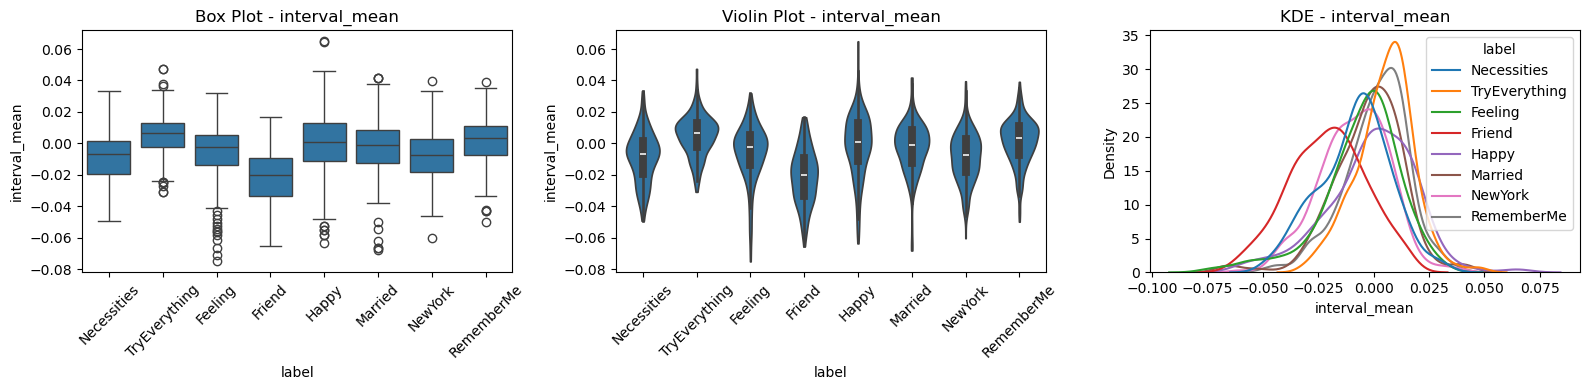

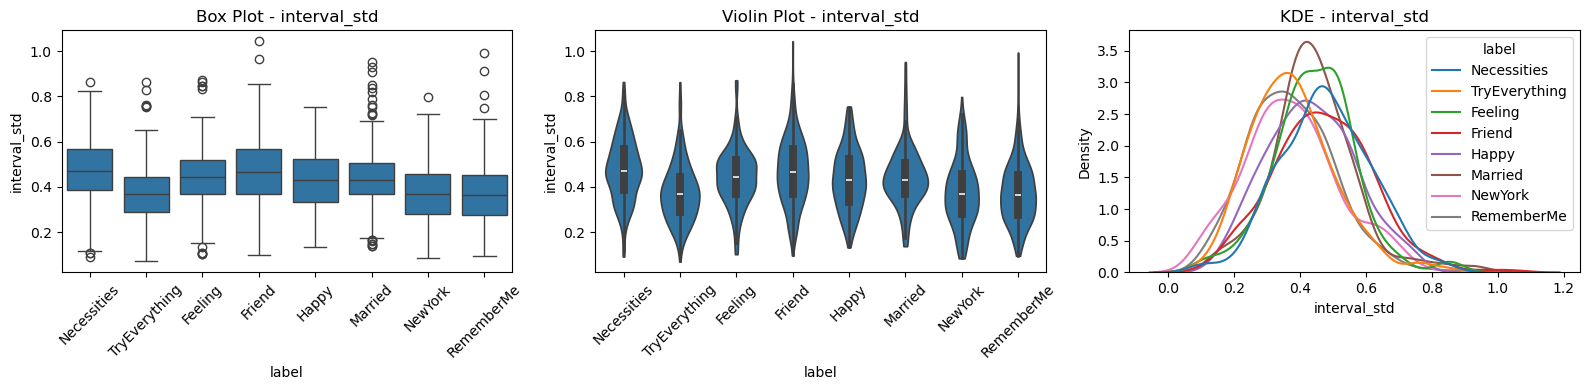

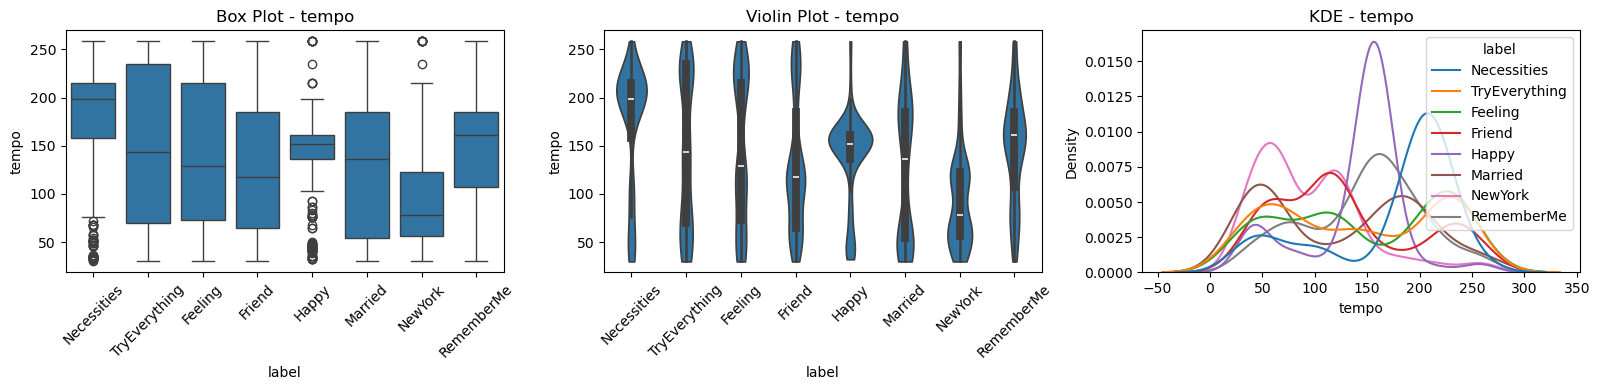

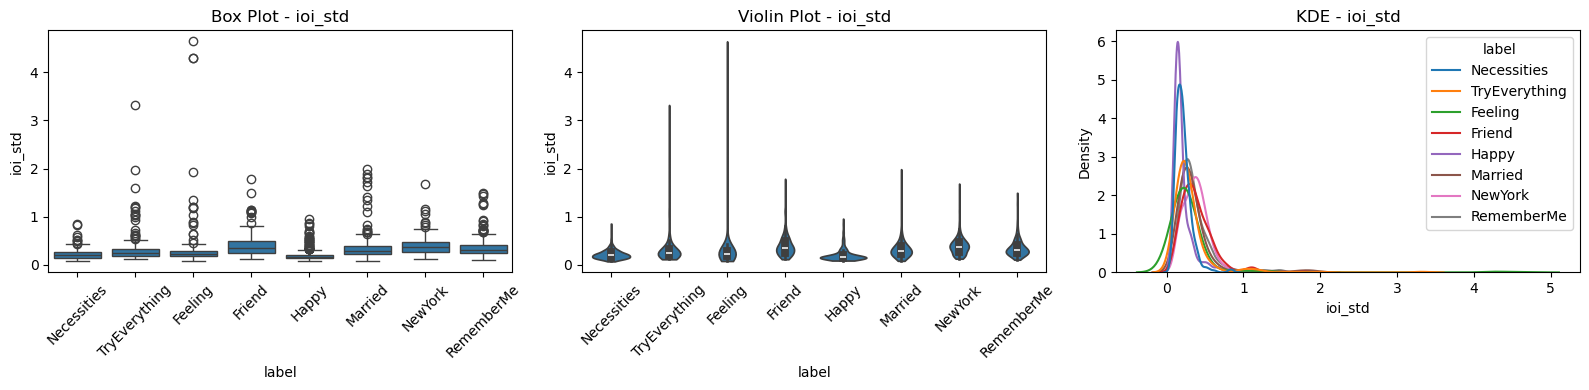

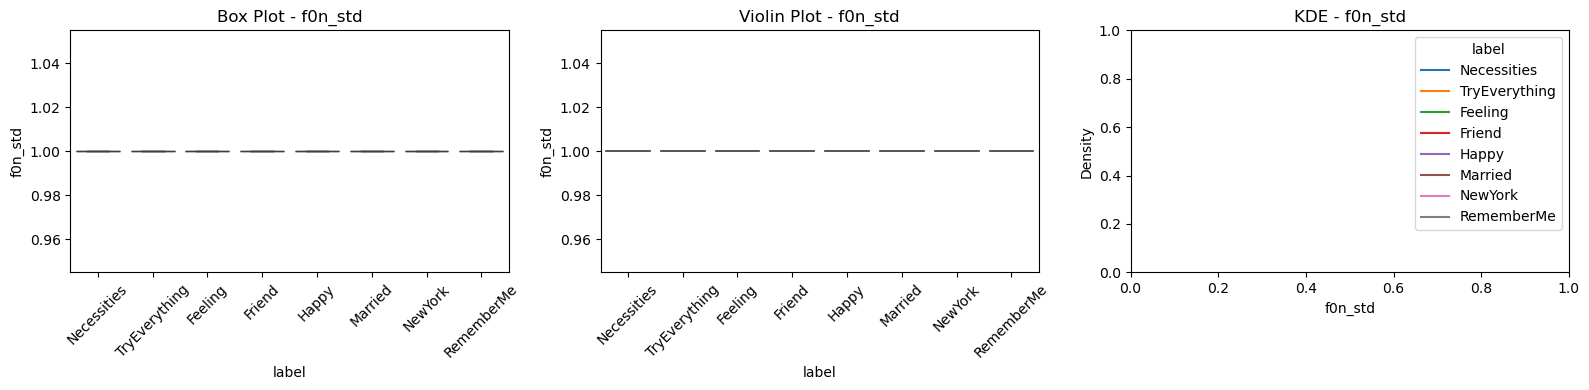

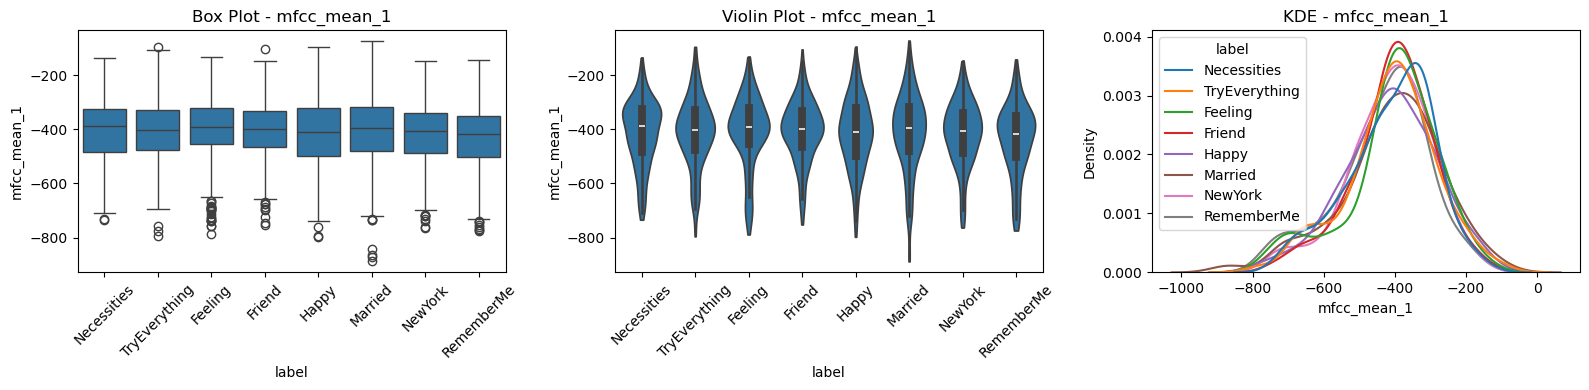

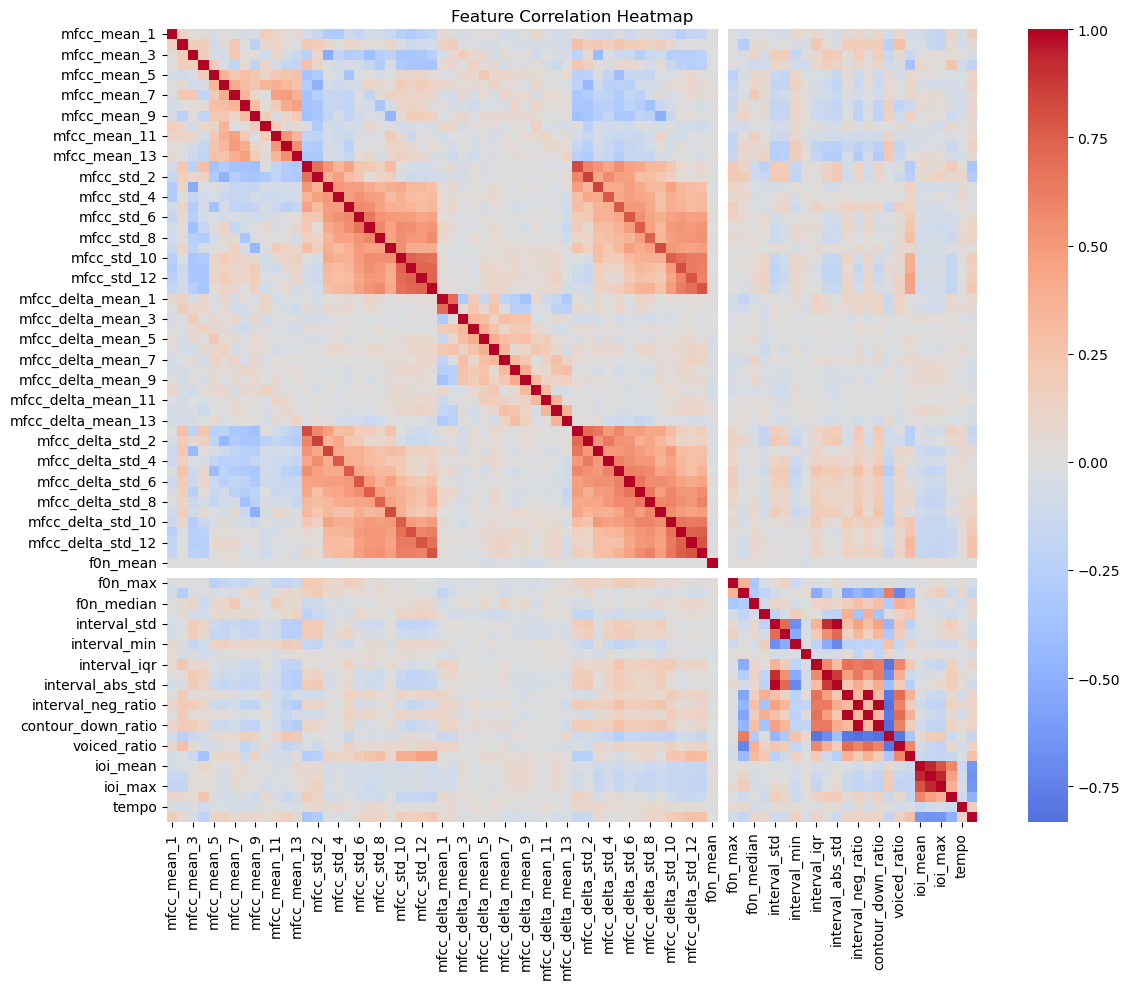

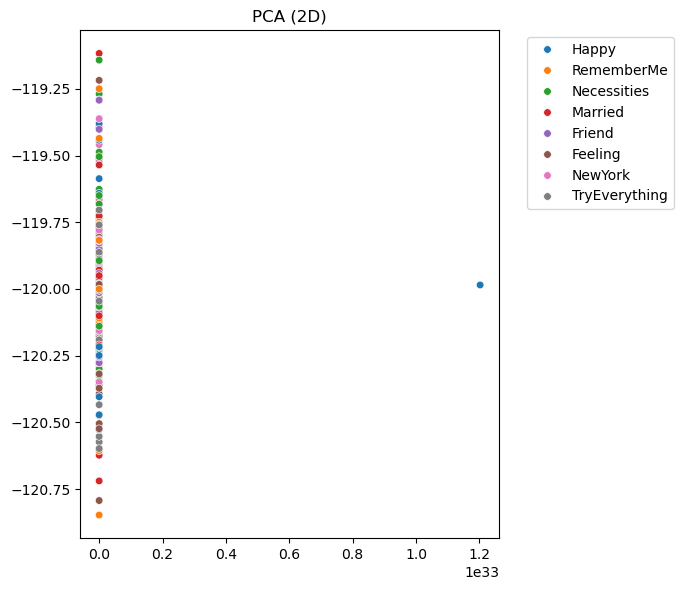

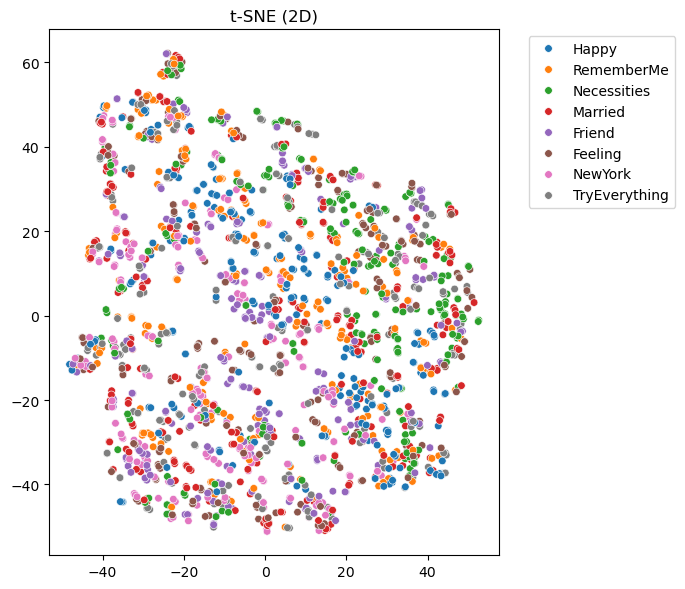

In [30]:
df = load_features_npz(DEFAULT_FEATURES)
feats = default_feature_list()
plot_box_violin_kde(df, feats, out_dir=None, show=True)
plot_corr_heatmap(df, out_dir=None, show=True)
plot_pca_tsne(df, out_dir=None, show=True)

In [ ]:
"""Notebook-friendly unsupervised analysis with K-Means and clustering metrics."""

from __future__ import annotations

import json
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import (
    adjusted_rand_score,
    confusion_matrix,
    normalized_mutual_info_score,
    silhouette_score,
)

# ---------------------------------------------------------------------
# 1) Paths (keep original .npz path)
# ---------------------------------------------------------------------
DEFAULT_FEATURES = Path(
    "/Users/panmingh/Code/ML_Coursework/MyCourse/results/splits/train_full.npz"
)
DEFAULT_OUT_DIR = Path("/Users/panmingh/Code/ML_Coursework/MyCourse/results")


# ---------------------------------------------------------------------
# 2) Config
# ---------------------------------------------------------------------
@dataclass
class UnsupervisedConfig:
    n_clusters: int = 8
    random_seed: int = 42
    max_points: int = 2000


# ---------------------------------------------------------------------
# 3) Data helpers
# ---------------------------------------------------------------------
def load_features_npz(path: Path) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    data = np.load(path, allow_pickle=True)
    X = data["X"]
    labels = data["labels"].astype(str)
    feature_names = data["feature_names"].astype(str)
    return X, labels, feature_names


def subset_data(
    X: np.ndarray, y: np.ndarray, cfg: UnsupervisedConfig
) -> Tuple[np.ndarray, np.ndarray]:
    if X.shape[0] <= cfg.max_points:
        return X, y
    rng = np.random.default_rng(cfg.random_seed)
    idx = rng.choice(X.shape[0], size=cfg.max_points, replace=False)
    return X[idx], y[idx]


# ---------------------------------------------------------------------
# 4) Metrics + plots (show inline + optional save)
# ---------------------------------------------------------------------
def compute_metrics(X: np.ndarray, y: np.ndarray, clusters: np.ndarray) -> Dict[str, float]:
    nmi = normalized_mutual_info_score(y, clusters)
    ari = adjusted_rand_score(y, clusters)
    sil = silhouette_score(X, clusters) if len(np.unique(clusters)) > 1 else 0.0
    return {"nmi": float(nmi), "ari": float(ari), "silhouette": float(sil)}


def _finish_plot(fig: plt.Figure, out_path: Path | None, show: bool) -> None:
    fig.tight_layout()
    if out_path is not None:
        fig.savefig(out_path, dpi=150)
    if show:
        plt.show()
    plt.close(fig)


def plot_confusion(
    y: np.ndarray,
    clusters: np.ndarray,
    out_path: Path | None = None,
    show: bool = True,
) -> None:
    labels = np.unique(y)
    conf = confusion_matrix(y, clusters, labels=labels)
    row_sums = conf.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    conf_norm = conf / row_sums
    df = pd.DataFrame(
        conf_norm, index=labels, columns=[f"C{i}" for i in range(conf.shape[1])]
    )
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(
        df,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        vmin=0.0,
        vmax=1.0,
        ax=ax,
    )
    ax.set_title("Cluster vs Label Confusion (Row-Normalized)")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Label")
    _finish_plot(fig, out_path, show)


def save_metrics(metrics: Dict[str, float], out_dir: Path | None = None) -> None:
    if out_dir is None:
        return
    out_dir.mkdir(parents=True, exist_ok=True)
    metrics_path = out_dir / "unsupervised_metrics.json"
    with metrics_path.open("w", encoding="utf-8") as f:
        json.dump(metrics, f, ensure_ascii=False, indent=2)

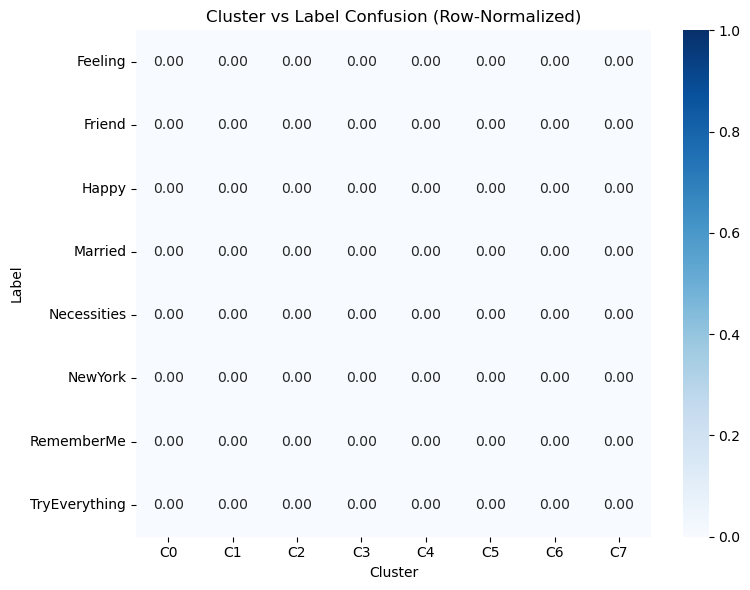

In [32]:
# ---------------------------------------------------------------------
# 5) Example "notebook flow" (copy into cells if desired)
# ---------------------------------------------------------------------
cfg = UnsupervisedConfig(n_clusters=8)
X, y, _ = load_features_npz(DEFAULT_FEATURES)
X, y = subset_data(X, y, cfg)
kmeans = KMeans(n_clusters=cfg.n_clusters, random_state=cfg.random_seed, n_init=10)
clusters = kmeans.fit_predict(X)
metrics = compute_metrics(X, y, clusters)
metrics
plot_confusion(y, clusters, out_path=None, show=True)
save_metrics(metrics, DEFAULT_OUT_DIR)

In [33]:
from __future__ import annotations

import json
import warnings
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Dict, List, Tuple

import numpy as np
from joblib import dump
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler

try:
    import torch
    import torch.nn as nn
    from torch.utils.data import DataLoader, Dataset
except Exception:
    torch = None

try:
    from tqdm import tqdm
except Exception:  # pragma: no cover
    tqdm = None

import librosa

# ---------------------------------------------------------------------
# 1) Paths (keep original .npz paths)
# ---------------------------------------------------------------------
DEFAULT_TRAIN = Path("/Users/panmingh/Code/ML_Coursework/MyCourse/results/splits/train_full.npz")
DEFAULT_VAL = Path("/Users/panmingh/Code/ML_Coursework/MyCourse/results/splits/val.npz")
DEFAULT_OUT = Path("/Users/panmingh/Code/ML_Coursework/MyCourse/results")
DEFAULT_MODEL = Path("/Users/panmingh/Code/ML_Coursework/MyCourse/models/final_model.pkl")


# ---------------------------------------------------------------------
# 2) Config
# ---------------------------------------------------------------------
@dataclass
class TrainConfig:
    n_splits: int = 5
    random_seed: int = 42


@dataclass
class MLPStableConfig:
    hidden_layer_sizes: Tuple[int, int] = (128, 64)
    alpha: float = 1e-3
    lr: float = 1e-3
    epochs: int = 200


# ---------------------------------------------------------------------
# 3) Loading + logging
# ---------------------------------------------------------------------
def load_features(path: Path) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    data = np.load(path, allow_pickle=True)
    X = data["X"].astype(np.float32)
    y = data["labels"].astype(str)
    paths = data["paths"].astype(str)
    return X, y, paths


def log_feature_stats(name: str, X: np.ndarray) -> None:
    finite_mask = np.isfinite(X)
    finite_ratio = float(np.mean(finite_mask))
    print(
        f"[{name}] shape={X.shape} finite={finite_ratio:.3f} "
        f"min={np.nanmin(X):.4f} max={np.nanmax(X):.4f}"
    )


def log_label_stats(name: str, y: np.ndarray) -> None:
    unique, counts = np.unique(y, return_counts=True)
    dist = ", ".join([f"{u}:{c}" for u, c in zip(unique, counts)])
    print(f"[{name}] samples={len(y)} classes={len(unique)} dist={{ {dist} }}")


# ---------------------------------------------------------------------
# 4) Preprocessing helpers
# ---------------------------------------------------------------------
def sanitize_features(
    X_train: np.ndarray, X_val: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
    X_val = np.nan_to_num(X_val, nan=0.0, posinf=0.0, neginf=0.0)
    low = np.percentile(X_train, 1, axis=0)
    high = np.percentile(X_train, 99, axis=0)
    X_train = np.clip(X_train, low, high)
    X_val = np.clip(X_val, low, high)
    return X_train, X_val


def compute_clip_bounds(
    X: np.ndarray, low_q: float = 1.0, high_q: float = 99.0
) -> Tuple[np.ndarray, np.ndarray]:
    low = np.percentile(X, low_q, axis=0)
    high = np.percentile(X, high_q, axis=0)
    return low, high


def apply_clip(X: np.ndarray, low: np.ndarray, high: np.ndarray) -> np.ndarray:
    return np.clip(X, low, high)


def preprocess_mlp(
    X_train: np.ndarray, X_val: np.ndarray
) -> Tuple[np.ndarray, np.ndarray, StandardScaler, Tuple[np.ndarray, np.ndarray]]:
    X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float64)
    X_val = np.nan_to_num(X_val, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float64)
    low, high = compute_clip_bounds(X_train, low_q=1.0, high_q=99.0)
    X_train = apply_clip(X_train, low, high)
    X_val = apply_clip(X_val, low, high)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    X_train = np.clip(X_train, -3.0, 3.0)
    X_val = np.clip(X_val, -3.0, 3.0)
    return X_train, X_val, scaler, (low, high)


# ---------------------------------------------------------------------
# 5) Metrics
# ---------------------------------------------------------------------
def macro_auc(y_true: np.ndarray, y_proba: np.ndarray, classes: List[int]) -> float:
    try:
        return float(
            roc_auc_score(
                y_true,
                y_proba,
                multi_class="ovr",
                average="macro",
                labels=classes,
            )
        )
    except Exception:
        return float("nan")


def evaluate_metrics(
    y_true: np.ndarray, y_pred: np.ndarray, y_proba: np.ndarray
) -> Dict[str, float]:
    classes = sorted(np.unique(y_true).tolist())
    return {
        "macro_auc": macro_auc(y_true, y_proba, classes),
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "macro_f1": float(f1_score(y_true, y_pred, average="macro")),
    }


# ---------------------------------------------------------------------
# 6) CV search
# ---------------------------------------------------------------------
def cv_score(
    build_model: Any,
    param_grid: List[Dict[str, Any]],
    X: np.ndarray,
    y: np.ndarray,
    cfg: TrainConfig,
) -> Tuple[Dict[str, Any], float, int]:
    skf = StratifiedKFold(n_splits=cfg.n_splits, shuffle=True, random_state=cfg.random_seed)
    best_params: Dict[str, Any] = {}
    best_score = -np.inf
    failed_folds = 0
    iterator = tqdm(param_grid, desc="CV params", unit="cfg") if tqdm else param_grid
    for params in iterator:
        scores = []
        for train_idx, val_idx in skf.split(X, y):
            model = build_model(params)
            try:
                model.fit(X[train_idx], y[train_idx])
                y_proba = model.predict_proba(X[val_idx])
                score = macro_auc(y[val_idx], y_proba, sorted(np.unique(y).tolist()))
                if not np.isnan(score):
                    scores.append(score)
            except ValueError:
                failed_folds += 1
                continue
        mean_score = float(np.mean(scores)) if scores else float("-inf")
        if mean_score > best_score:
            best_score = mean_score
            best_params = params
    return best_params, best_score, failed_folds


def build_knn(params: Dict[str, Any]) -> Pipeline:
    return Pipeline(
        [
            ("scaler", StandardScaler()),
            ("clf", KNeighborsClassifier(**params)),
        ]
    )


def build_rf(params: Dict[str, Any]) -> RandomForestClassifier:
    return RandomForestClassifier(random_state=42, **params)


def train_mlp_stable(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_val: np.ndarray,
    y_val: np.ndarray,
    cfg: MLPStableConfig,
) -> Tuple[MLPClassifier, Dict[str, float]]:
    model = MLPClassifier(
        hidden_layer_sizes=cfg.hidden_layer_sizes,
        solver="adam",
        activation="relu",
        learning_rate_init=cfg.lr,
        learning_rate="adaptive",
        alpha=cfg.alpha,
        max_iter=cfg.epochs,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10,
        random_state=42,
    )
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_val)
    y_pred = np.argmax(y_proba, axis=1)
    metrics = evaluate_metrics(y_val, y_pred, y_proba)
    return model, metrics


# ---------------------------------------------------------------------
# 7) CNN utilities (optional)
# ---------------------------------------------------------------------
class MFCCDataset(Dataset):
    def __init__(
        self,
        paths: List[str],
        labels: np.ndarray,
        label_encoder: LabelEncoder,
        sr: int,
        n_mfcc: int,
    ):
        self.paths = paths
        self.labels = label_encoder.transform(labels)
        self.sr = sr
        self.n_mfcc = n_mfcc

    def __len__(self) -> int:
        return len(self.paths)

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, int]:
        path = self.paths[idx]
        y, _ = librosa.load(path, sr=self.sr, mono=True)
        mfcc = librosa.feature.mfcc(y=y, sr=self.sr, n_mfcc=self.n_mfcc)
        return mfcc.astype(np.float32), int(self.labels[idx])


class SimpleCNN(nn.Module):
    def __init__(self, n_mfcc: int, n_classes: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(n_mfcc, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1),
        )
        self.fc = nn.Linear(64, n_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.net(x)
        x = x.squeeze(-1)
        return self.fc(x)


def collate_pad(batch: List[Tuple[np.ndarray, int]]) -> Tuple[torch.Tensor, torch.Tensor]:
    lengths = [b[0].shape[1] for b in batch]
    max_len = max(lengths)
    n_mfcc = batch[0][0].shape[0]
    padded = np.zeros((len(batch), n_mfcc, max_len), dtype=np.float32)
    labels = np.zeros(len(batch), dtype=np.int64)
    for i, (mfcc, label) in enumerate(batch):
        padded[i, :, : mfcc.shape[1]] = mfcc
        labels[i] = label
    return torch.from_numpy(padded), torch.from_numpy(labels)


def train_cnn(
    train_paths: List[str],
    train_labels: np.ndarray,
    val_paths: List[str],
    val_labels: np.ndarray,
    label_encoder: LabelEncoder,
    epochs: int = 20,
    batch_size: int = 16,
    lr: float = 1e-3,
    device: str = "cpu",
) -> Tuple[Dict[str, float], Dict[str, Any]]:
    if torch is None:
        raise RuntimeError("PyTorch is required for CNN training.")

    n_mfcc = 13
    n_classes = len(label_encoder.classes_)
    train_ds = MFCCDataset(train_paths, train_labels, label_encoder, sr=22050, n_mfcc=n_mfcc)
    val_ds = MFCCDataset(val_paths, val_labels, label_encoder, sr=22050, n_mfcc=n_mfcc)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_pad)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_pad)

    model = SimpleCNN(n_mfcc=n_mfcc, n_classes=n_classes).to(device)
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for _ in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            optim.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optim.step()

    model.eval()
    all_probs = []
    all_true = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            logits = model(xb)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_true.append(yb.numpy())

    y_true = np.concatenate(all_true)
    y_proba = np.vstack(all_probs)
    y_pred = np.argmax(y_proba, axis=1)
    metrics = evaluate_metrics(y_true, y_pred, y_proba)
    return metrics, {"model": model, "label_encoder": label_encoder}


def filter_existing_audio(paths: np.ndarray, labels: np.ndarray) -> Tuple[List[str], np.ndarray]:
    out_paths: List[str] = []
    out_labels: List[str] = []
    for p, y in zip(paths, labels):
        if "::" in p:
            continue
        if Path(p).is_file():
            out_paths.append(p)
            out_labels.append(y)
    return out_paths, np.asarray(out_labels)

In [34]:
# ---------------------------------------------------------------------
# 8) Example "notebook flow" (copy into cells if desired)
# ---------------------------------------------------------------------
X_train, y_train, train_paths = load_features(DEFAULT_TRAIN)
X_val, y_val, val_paths = load_features(DEFAULT_VAL)
X_train, X_val = sanitize_features(X_train, X_val)
log_feature_stats("train", X_train)
log_feature_stats("val", X_val)
log_label_stats("train", y_train)
log_label_stats("val", y_val)
print(f"[paths] train_paths={len(train_paths)} val_paths={len(val_paths)}")

le = LabelEncoder()
le.fit(np.concatenate([y_train, y_val]))
y_train_enc = le.transform(y_train)
y_val_enc = le.transform(y_val)

cfg = TrainConfig()
results: Dict[str, Any] = {}

knn_grid = [
    {"n_neighbors": k, "weights": w}
    for k in [3, 5, 7, 9]
    for w in ["uniform", "distance"]
]
rf_grid = [
    {"n_estimators": n, "max_depth": d}
    for n in [100, 200]
    for d in [5, 10, None]
]
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

for name, builder, grid in [
    ("knn", build_knn, knn_grid),
    ("rf", build_rf, rf_grid),
]:
    if tqdm is None:
        print(f"Training {name}...")
    print(f"[{name}] cv_folds={cfg.n_splits} grid_size={len(grid)}")
    best_params, cv_auc, failed_folds = cv_score(builder, grid, X_train, y_train_enc, cfg)
    try:
        model = builder(best_params)
        model.fit(X_train, y_train_enc)
        y_proba = model.predict_proba(X_val)
        y_pred = np.argmax(y_proba, axis=1)
        metrics = evaluate_metrics(y_val_enc, y_pred, y_proba)
        results[name] = {"best_params": best_params, "cv_macro_auc": cv_auc, "val": metrics}
        print(
            f"[{name}] cv_macro_auc={cv_auc:.4f} "
            f"val_auc={metrics['macro_auc']:.4f} "
            f"val_acc={metrics['accuracy']:.4f} "
            f"val_f1={metrics['macro_f1']:.4f} "
            f"failed_folds={failed_folds}"
        )
    except ValueError as exc:
        results[name] = {
            "best_params": best_params,
            "cv_macro_auc": cv_auc,
            "error": str(exc),
        }
        print(f"[{name}] failed after CV: {exc} failed_folds={failed_folds}")

mlp_cfg = MLPStableConfig()
X_train_mlp, X_val_mlp, mlp_scaler, clip_bounds = preprocess_mlp(X_train, X_val)
try:
    mlp_model, mlp_metrics = train_mlp_stable(
        X_train_mlp, y_train_enc, X_val_mlp, y_val_enc, mlp_cfg
    )
    results["mlp"] = {
        "config": mlp_cfg.__dict__,
        "val": mlp_metrics,
    }
    print(
        f"[mlp] val_auc={mlp_metrics['macro_auc']:.4f} "
        f"val_acc={mlp_metrics['accuracy']:.4f} "
        f"val_f1={mlp_metrics['macro_f1']:.4f}"
    )
except ValueError as exc:
    results["mlp"] = {"config": mlp_cfg.__dict__, "error": str(exc)}
    print(f"[mlp] failed: {exc}")

# Optional CNN (requires torch)
include_cnn = False
if include_cnn and torch is not None:
    train_audio, y_train_audio = filter_existing_audio(train_paths, y_train)
    val_audio, y_val_audio = filter_existing_audio(val_paths, y_val)
    if train_audio and val_audio:
        cnn_metrics, cnn_artifacts = train_cnn(
            train_audio,
            y_train_audio,
            val_audio,
            y_val_audio,
            le,
            epochs=20,
        )
        results["cnn"] = {"val": cnn_metrics}
    else:
        results["cnn"] = {"error": "No valid audio paths for CNN."}

def _score(name: str) -> float:
    val_score = results.get(name, {}).get("val", {}).get("macro_auc", float("-inf"))
    return val_score if not np.isnan(val_score) else float("-inf")

best_name = max(results.keys(), key=_score)
results["best_model"] = best_name

DEFAULT_OUT.mkdir(parents=True, exist_ok=True)
with (DEFAULT_OUT / "train_metrics.json").open("w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

if best_name == "cnn":
    payload = cnn_artifacts
else:
    # Retrain best sklearn model on Train+Val
    X_full = np.vstack([X_train, X_val])
    y_full = np.concatenate([y_train_enc, y_val_enc])
    if best_name == "knn":
        final_model = build_knn(results["knn"]["best_params"])
        final_model.fit(X_full, y_full)
        payload = {"model": final_model, "label_encoder": le}
    elif best_name == "rf":
        final_model = build_rf(results["rf"]["best_params"])
        final_model.fit(X_full, y_full)
        payload = {"model": final_model, "label_encoder": le}
    else:
        X_full_mlp, _, mlp_scaler, clip_bounds = preprocess_mlp(X_full, X_full)
        final_model = MLPClassifier(
            hidden_layer_sizes=mlp_cfg.hidden_layer_sizes,
            solver="adam",
            activation="relu",
            learning_rate_init=mlp_cfg.lr,
            learning_rate="adaptive",
            alpha=mlp_cfg.alpha,
            max_iter=mlp_cfg.epochs,
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=10,
            random_state=42,
        )
        final_model.fit(X_full_mlp, y_full)
        payload = {
            "model": final_model,
            "label_encoder": le,
            "scaler": mlp_scaler,
            "clip_bounds": clip_bounds,
        }
    DEFAULT_MODEL.parent.mkdir(parents=True, exist_ok=True)
    dump(payload, DEFAULT_MODEL)


[train] shape=(2252, 78) finite=1.000 min=-741.9331 max=258.3984
[val] shape=(115, 78) finite=1.000 min=-715.3228 max=258.3984
[train] samples=2252 classes=8 dist={ Feeling:276, Friend:292, Happy:284, Married:288, Necessities:284, NewYork:272, RememberMe:284, TryEverything:272 }
[val] samples=115 classes=8 dist={ Feeling:14, Friend:15, Happy:14, Married:12, Necessities:14, NewYork:16, RememberMe:15, TryEverything:15 }
[paths] train_paths=2252 val_paths=115
[knn] cv_folds=5 grid_size=8


CV params: 100%|██████████| 8/8 [00:00<00:00, 42.54cfg/s]


[knn] cv_macro_auc=0.9430 val_auc=0.5652 val_acc=0.2000 val_f1=0.1948 failed_folds=0
[rf] cv_folds=5 grid_size=6


CV params: 100%|██████████| 6/6 [00:17<00:00,  2.94s/cfg]


[rf] cv_macro_auc=0.9775 val_auc=0.7795 val_acc=0.4000 val_f1=0.3937 failed_folds=0
[mlp] val_auc=0.7301 val_acc=0.3217 val_f1=0.3163


In [35]:
"""Notebook-friendly evaluation with inline visualizations."""

from __future__ import annotations

import json
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Tuple

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    auc,
    confusion_matrix,
    f1_score,
    roc_auc_score,
    roc_curve,
)

try:
    from joblib import load
except Exception:  # pragma: no cover
    load = None

# ---------------------------------------------------------------------
# 1) Paths (keep original .npz/model paths)
# ---------------------------------------------------------------------
DEFAULT_TEST = Path("/Users/panmingh/Code/ML_Coursework/MyCourse/results/splits/test.npz")
DEFAULT_MODEL = Path("/Users/panmingh/Code/ML_Coursework/MyCourse/models/final_model.pkl")
DEFAULT_OUT = Path("/Users/panmingh/Code/ML_Coursework/MyCourse/results")


# ---------------------------------------------------------------------
# 2) Config
# ---------------------------------------------------------------------
@dataclass
class EvalConfig:
    out_dir: Path = DEFAULT_OUT


# ---------------------------------------------------------------------
# 3) Loading + preprocessing
# ---------------------------------------------------------------------
def load_features(path: Path) -> Tuple[np.ndarray, np.ndarray]:
    data = np.load(path, allow_pickle=True)
    X = data["X"].astype(np.float32)
    y = data["labels"].astype(str)
    return X, y


def sanitize_features(X: np.ndarray) -> np.ndarray:
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    low = np.percentile(X, 1, axis=0)
    high = np.percentile(X, 99, axis=0)
    return np.clip(X, low, high)


def load_model(path: Path):
    if load is None:
        raise RuntimeError("joblib is required to load the model.")
    payload = load(path)
    if isinstance(payload, dict) and "model" in payload:
        return payload["model"], payload.get("label_encoder")
    return payload, None


# ---------------------------------------------------------------------
# 4) Metrics + plots (show inline + optional save)
# ---------------------------------------------------------------------
def compute_metrics(
    y_true: np.ndarray, y_pred: np.ndarray, y_proba: np.ndarray
) -> Dict[str, float]:
    labels = sorted(np.unique(y_true).tolist())
    metrics = {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "macro_f1": float(f1_score(y_true, y_pred, average="macro")),
    }
    try:
        metrics["macro_auc"] = float(
            roc_auc_score(
                y_true,
                y_proba,
                multi_class="ovr",
                average="macro",
                labels=labels,
            )
        )
    except Exception:
        metrics["macro_auc"] = float("nan")
    return metrics


def _finish_plot(fig: plt.Figure, out_path: Path | None, show: bool) -> None:
    fig.tight_layout()
    if out_path is not None:
        fig.savefig(out_path, dpi=150)
    if show:
        plt.show()
    plt.close(fig)


def plot_confusion_matrix(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    out_path: Path | None = None,
    show: bool = True,
) -> None:
    labels = sorted(np.unique(y_true).tolist())
    conf = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=labels)
    disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
    ax.set_title("Confusion Matrix (Test)")
    _finish_plot(fig, out_path, show)


def plot_confusion_normalized(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    out_path: Path | None = None,
    show: bool = True,
) -> None:
    labels = sorted(np.unique(y_true).tolist())
    conf = confusion_matrix(y_true, y_pred, labels=labels)
    row_sums = conf.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    conf_norm = conf / row_sums
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(
        conf_norm,
        cmap="Blues",
        vmin=0.0,
        vmax=1.0,
        annot=True,
        fmt=".2f",
        xticklabels=labels,
        yticklabels=labels,
        ax=ax,
    )
    ax.set_title("Confusion Matrix (Row-Normalized)")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    _finish_plot(fig, out_path, show)


def plot_roc_curves(
    y_true: np.ndarray,
    y_proba: np.ndarray,
    out_path: Path | None = None,
    show: bool = True,
) -> None:
    labels = sorted(np.unique(y_true).tolist())
    fig, ax = plt.subplots(figsize=(8, 6))
    for i, label in enumerate(labels):
        y_bin = (y_true == label).astype(int)
        fpr, tpr, _ = roc_curve(y_bin, y_proba[:, i])
        ax.plot(fpr, tpr, label=f"{label} (AUC {auc(fpr, tpr):.2f})")
    ax.plot([0, 1], [0, 1], "k--", linewidth=1)
    ax.set_title("ROC Curves (One-vs-Rest)")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(fontsize=8, loc="lower right")
    _finish_plot(fig, out_path, show)


def save_metrics(metrics: Dict[str, float], out_dir: Path | None = None) -> None:
    if out_dir is None:
        return
    out_dir.mkdir(parents=True, exist_ok=True)
    with (out_dir / "test_metrics.json").open("w", encoding="utf-8") as f:
        json.dump(metrics, f, ensure_ascii=False, indent=2)



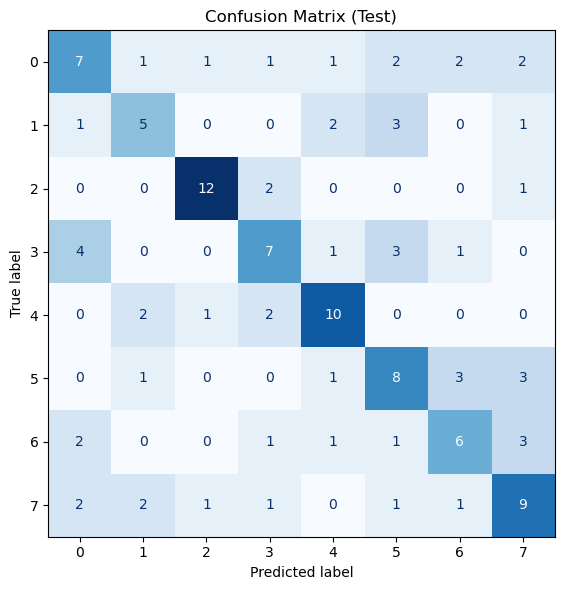

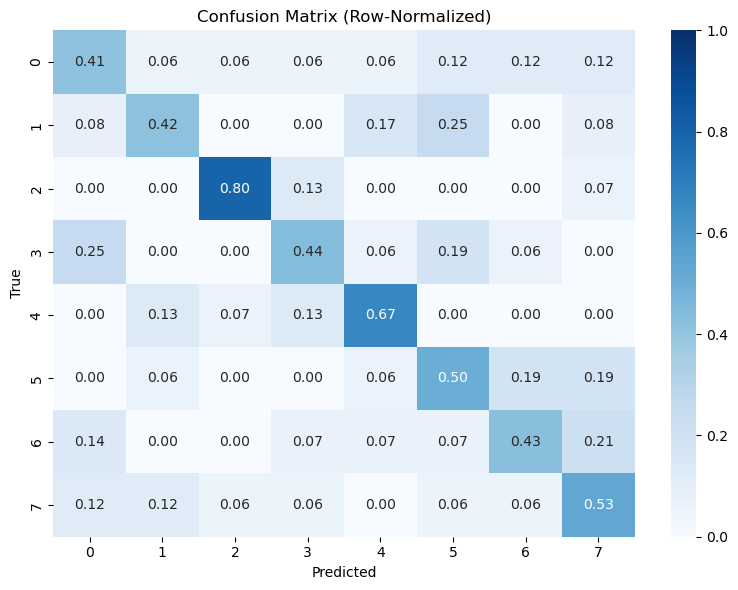

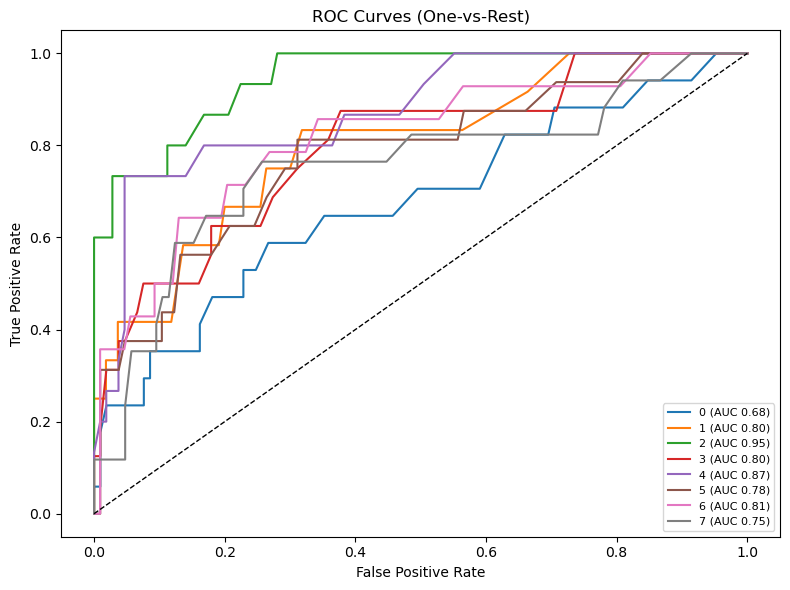

In [36]:


# ---------------------------------------------------------------------
# 5) Example "notebook flow" (copy into cells if desired)
# ---------------------------------------------------------------------
X_test, y_test = load_features(DEFAULT_TEST)
X_test = sanitize_features(X_test)
model, label_encoder = load_model(DEFAULT_MODEL)
y_true = label_encoder.transform(y_test) if label_encoder is not None else y_test
y_proba = model.predict_proba(X_test)
y_pred = np.argmax(y_proba, axis=1)
metrics = compute_metrics(y_true, y_pred, y_proba)
metrics
plot_confusion_matrix(y_true, y_pred, out_path=None, show=True)
plot_confusion_normalized(y_true, y_pred, out_path=None, show=True)
plot_roc_curves(y_true, y_proba, out_path=None, show=True)
save_metrics(metrics, DEFAULT_OUT)

## 7. Conclusion
Basic model implemented with limited performance.

## 8. References
Librosa, scikit-learn.